# Portafolios de Inversión
## Proyecto Final

Presenta :

- Juan Ramón López Rocha

- José Armando Melchor Soto

- Paula Ines Pelayo Morales
---



### Librerías


In [450]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import warnings
import seaborn as sns

warnings.filterwarnings('ignore')


---

### Funciones

#### Función Analisis de Acciones

In [451]:
def analizar_accion(ticker_f):
    accion = yf.Ticker(ticker_f)
    # Obtener datos
    info = accion.info
    current_price = info.get('regularMarketPrice', info.get('currentPrice', None))
    book_value_per_share = info.get('bookValue', None)
    trailing_eps = info.get('trailingEps', None)

    # Validar datos
    if None in (current_price, book_value_per_share, trailing_eps):
        return f"Error: No se pudo obtener alguno de los datos para {ticker_f}."

    # Cálculos
    price_to_book = current_price / book_value_per_share if book_value_per_share else None
    price_to_earnings = current_price / trailing_eps if trailing_eps else None

    # Evaluación P/B
    if price_to_book <= 1.2:
        evaluacion_pb = "P/B ≤ 1.2: Posible infravaloración (umbral de recompra de Buffett)."
    elif price_to_book <= 1.6:
        evaluacion_pb = "P/B entre 1.2–1.6: Valuación razonable (rango histórico)."
    else:
        evaluacion_pb = "P/B > 1.6: Posible sobrevaloración."

    # Evaluación P/E
    evaluacion_pe = f"P/E: {price_to_earnings:.2f}. Compara con el S&P 500 (~15–20) para contexto."

    # Resultados
    return (
        f"\nMétricas de {ticker_f}:\n"
        f"Precio Actual: ${current_price:.2f}\n"
        f"EPS (Trailing): ${trailing_eps:.2f}\n"
        f"Price-to-Book (P/B): {price_to_book:.2f}\n"
        f"Price-to-Earnings (P/E): {price_to_earnings:.2f}\n\n"
        f"Evaluación:\n{evaluacion_pb}\n{evaluacion_pe}"
    )


#### Clase Optimizar Pesos

In [452]:
class OptimizePortfolioWeights:

    def __init__(self, returns: pd.DataFrame, risk_free: float):

        self.rets = returns
        self.cov = returns.cov()
        self.rf = risk_free / 252
        self.n_stocks = len(returns.columns)

    # Min Variance
    def opt_min_var(self):


        var = lambda w: w.T @ self.cov @ w

        w0=np.ones(self.n_stocks)/self.n_stocks

        bounds=[(0, 1)]*self.n_stocks

        constraint=lambda w: sum(w)-1

        result=minimize(fun=var, x0=w0, bounds=bounds,
                        constraints={'fun': constraint, 'type': 'eq'},
                        tol=1e-16)

        return result.x

    # Sharpe Ratio
    def opt_max_sharpe(self):
        rets = self.rets
        rend, cov, rf = self.rets.mean(), self.cov, self.rf

        sr = lambda w: -((np.dot(rend, w) - rf) / ((w.reshape(-1, 1).T @ cov @ w) ** 0.5))

        result = minimize(sr, np.ones(len(rets.T)), bounds=[(0, None)] * len(rets.T),
                          constraints={'fun': lambda w: sum(w) - 1, 'type': 'eq'},
                          tol=1e-16)

        return result.x

    # Semivariance method
    def opt_min_semivar(self, rets_benchmark):

        rets, corr=self.rets.copy(), self.rets.corr()

        diffs=rets-rets_benchmark.values

        below_zero_target=diffs[diffs<0].fillna(0)
        target_downside=np.array(below_zero_target.std())

        target_semivariance=np.multiply(target_downside.reshape(len(target_downside), 1), target_downside) * corr

        semivar = lambda w: w.T @ target_semivariance @ w

        w0=np.ones(self.n_stocks)/self.n_stocks

        bounds=[(0, 3)]*self.n_stocks

        constraint=lambda w: sum(w)-1

        result=minimize(fun=semivar, x0=w0, bounds=bounds,
                        constraints={'fun': constraint, 'type': 'eq'}, tol=1e-16)

        return result.x

    # Omega
    def opt_max_omega(self, rets_benchmark):

        rets=self.rets.copy()

        diffs=rets-rets_benchmark.values

        below_zero_target=diffs[diffs<0].fillna(0)
        above_zero_target=diffs[diffs>0].fillna(0)

        target_downside=np.array(below_zero_target.std())
        target_upside=np.array(above_zero_target.std())
        o=target_upside/target_downside

        omega = lambda w: -sum(o * w)


        w0=np.ones(self.n_stocks)/self.n_stocks

        bounds=[(0.05,0.4 )]*self.n_stocks

        constraint=lambda w: sum(w)-1

        result=minimize(fun=omega, x0=w0, bounds=bounds,
                        constraints={'fun': constraint, 'type': 'eq'}, tol=1e-16)

        return result.x


#### Clase Dynamic Backtesting

In [453]:
capital = 1000000

In [454]:
class dynamic_backtesting:
    
    # Definir las variables que necesitamos dentro de todas las funciones
    def __init__(self, prices, prices_benchmark, capital, rf, months):
        self.prices = prices # Atributo para los precios que se almacena en self 
        self.prices_benchmark=prices_benchmark # Atributo para los precios del benchmark que se almacena en self 
        self.months = months # Atributo para los meses que se almacena en self 
        self.capital = capital # Atributos para el capital que se almacena en self 
        self.rf = rf  # Atributa de tasa libre riesgo que se almacena en self 
        


# self es el objeto donde se almacenan los atributos

    # Clase para optimizar los pesos
    def optimize_weights(self, prices: pd.DataFrame, n_days: int, periods: int):
        
        temp_data = prices.iloc[int(n_days * periods):int(n_days * (periods + 1)), :]   # Extrae el subconjunto de precios actual para el periodo de optimización
        
        temp_bench = self.prices_benchmark.copy().iloc[int(n_days * periods):int(n_days * (periods + 1)), :]    #Extrae el subconjunto de precios del benchmark para el periodo de optimización

        temp_rets = temp_data.pct_change().dropna()  # Calcula los rendimientientos del periodo de optimización
        rets_benchmark = temp_bench.pct_change().dropna() # Calcula los rendimientos del benchmark para el periodo de optimización

        
        optimizer = OptimizePortfolioWeights(returns=temp_rets, risk_free=self.rf)  # Se utiliza la clase anterior que contiene los rendimientos del periodo de optimización y contiene el atributo de la tasa libre de riesgo
        w_minvar=optimizer.opt_min_var()
        w_sharpe=optimizer.opt_max_sharpe()
        w_semivar=optimizer.opt_min_semivar(rets_benchmark)
        w_omega=optimizer.opt_max_omega(rets_benchmark)
        # Se obtienen los pesos de cada uno de los métodos de optimización

        return w_minvar, w_sharpe, w_semivar, w_omega # Se devuelven los pesos de los metodos de optimización

    def simulation(self): # Se utiliza el objeto de almacenimiento de los atributos para realizar la simulación de bt
        
        n_days = round(len(self.prices) / round(len(self.prices) / 252 / (self.months / 12)), 0) # Son los días redondeados a 0 decimales , son los numero de dias del periodo de la simulación/bt
        
        capital = self.capital  # Es el capital inicial de la simulación/bt
             
        opt_data = self.prices.copy().iloc[:int(n_days), :]    # Se hace una copia de los precios y se extrae el subconjunto de los precios para el period de optimización
        
        backtesting_data = self.prices.copy().iloc[int(n_days):, :] # Se hace una copia de los precios y se extrae el subconjunto de los precios para el periodo de simulación/bt
        
        backtesting_rets = backtesting_data.pct_change().dropna() # Se calculan los rendimientos del periodo de simulación/bt
        
        backtesting_bench =self.prices_benchmark.copy().iloc[int(n_days):, :].pct_change().dropna() # Se hace una copia de los precios de benchmark y se extrae el subconjunto de los precios para el periodo y se calculan los rendimientos 
        
        day_counter, periods_counter = 0, 0 # Se inicializa los contadores de los días y de los periodos 
        
        minvar, sharpe, semivar, omega = [capital], [capital], [capital], [capital] # Lista para almacenar el capital a lo largo del tiempo para estrategia 
        
        w_minvar, w_sharpe, w_semivar, w_omega = self.optimize_weights(opt_data, n_days, 0) # Se obtienne los pesos optimizados
        
        for day in range(len(backtesting_data) - 1): # Se itera dia a dia para 
            
            
            if day_counter < n_days: # Si el contador de dias es menor al numero de didas de optmización , hace : 

                sharpe.append(sharpe[-1] * (1 + sum(backtesting_rets.iloc[day, :] * w_sharpe)))  
                minvar.append(minvar[-1] * (1 + sum(backtesting_rets.iloc[day, :] * w_minvar)))
                semivar.append(semivar[-1] * (1 + sum(backtesting_rets.iloc[day, :] * w_semivar)))
                omega.append(omega[-1] * (1 + sum(backtesting_rets.iloc[day, :] * w_omega)))

            else:
                
                w_minvar, w_sharpe, w_semivar, w_omega = self.optimize_weights(backtesting_data, n_days, periods_counter)
                    
                sharpe.append(sharpe[-1] * (1 + sum(backtesting_rets.iloc[day, :] * w_sharpe)))
                minvar.append(minvar[-1] * (1 + sum(backtesting_rets.iloc[day, :] * w_minvar)))
                semivar.append(semivar[-1] * (1 + sum(backtesting_rets.iloc[day, :] * w_semivar)))
                omega.append(omega[-1] * (1 + sum(backtesting_rets.iloc[day, :] * w_omega)))
                
                periods_counter += 1
                day_counter = 0

            day_counter += 1
        
        df = pd.DataFrame()
        df['Date'] = backtesting_data.index
        df['Date'] = pd.to_datetime(df['Date'])
        df['Min Var'] = minvar
        df['Sharpe'] = sharpe
        df['Semivar'] = semivar
        df['Omega'] = omega
        df.set_index('Date', inplace=True)

        return df




#### Función Métricas de Desempeño

In [455]:
def get_metrics(history, rf):

    # Eliminar columnas completamente NaN
    history_clean = history.dropna(axis=1, how='all')

    # Filtrar columnas con valores no escalares (ej. Series u objetos)
    history_clean = history_clean.loc[:, history_clean.applymap(lambda x: isinstance(x, (int, float, np.float64, np.int64, np.number))).all()]

    # Eliminar columnas con solo un valor único (sin variación)
    history_clean = history_clean.loc[:, history_clean.nunique() > 1]

    # Validar que queden columnas útiles
    if history_clean.empty:
        raise ValueError("El DataFrame de history no tiene columnas válidas para calcular métricas. "
                         "Revisa tus datos o tu simulación.")

    daily_rets = history_clean.pct_change().dropna()
    cov= daily_rets.cov()

    rend_prom = daily_rets.mean() * 252
    std__ = daily_rets.std() * np.sqrt(252)
    RS = (rend_prom - rf) / std__
    downside = daily_rets[daily_rets < 0].fillna(0).std() * np.sqrt(252)
    upside = daily_rets[daily_rets > 0].fillna(0).std() * np.sqrt(252)
    Omega = upside / downside
    Sortino = (rend_prom - rf) / downside

    metrics = pd.DataFrame(
        [rend_prom, std__, RS, downside, upside ,Omega, Sortino],
        index=['Rend', 'Vol', 'Sharpe', 'Downside', 'Upside','Omega','Sortino']
    )

    
    return metrics

---

### Obtención de Datos

In [456]:
tickers = yf.download(['BRK-B', 'AZO', 'META','NEM','ED','WMT'], start='2024-01-01', end='2025-07-01' ,progress=False,)['Close']
benchmark = yf.download('^GSPC', start='2024-01-01', end='2025-07-01',progress=False)['Close']


In [457]:
ret = tickers.pct_change().dropna()
rets_benchmark = benchmark.pct_change().dropna()

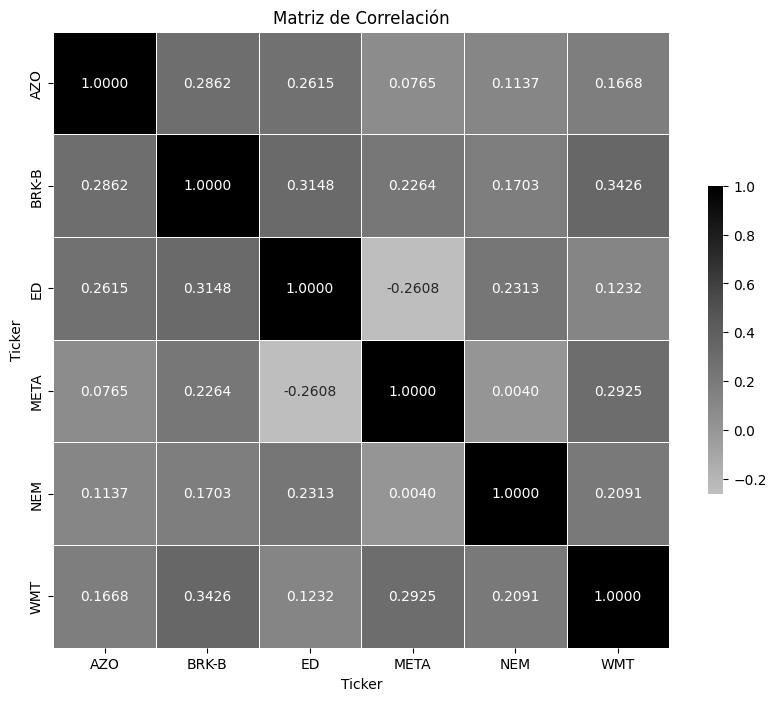

In [458]:
corr = ret.corr()
plt.figure(figsize=(10, 8))  

sns.heatmap(corr, annot=True, fmt=".4f", cmap='Greys', center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.title('Matriz de Correlación')
plt.show()

In [459]:
tickers_valuation = ['AZO', 'META','NEM','ED','WMT']
def get_financials(ticker:str) -> pd.DataFrame:
    bs = yf.Ticker(ticker).balance_sheet.iloc[:, :-1]
    ist = yf.Ticker(ticker).income_stmt.iloc[:, :-1]
    cf = yf.Ticker(ticker).cash_flow.iloc[:, :-1]

    return bs, ist, cf

Múltiplos de AZO


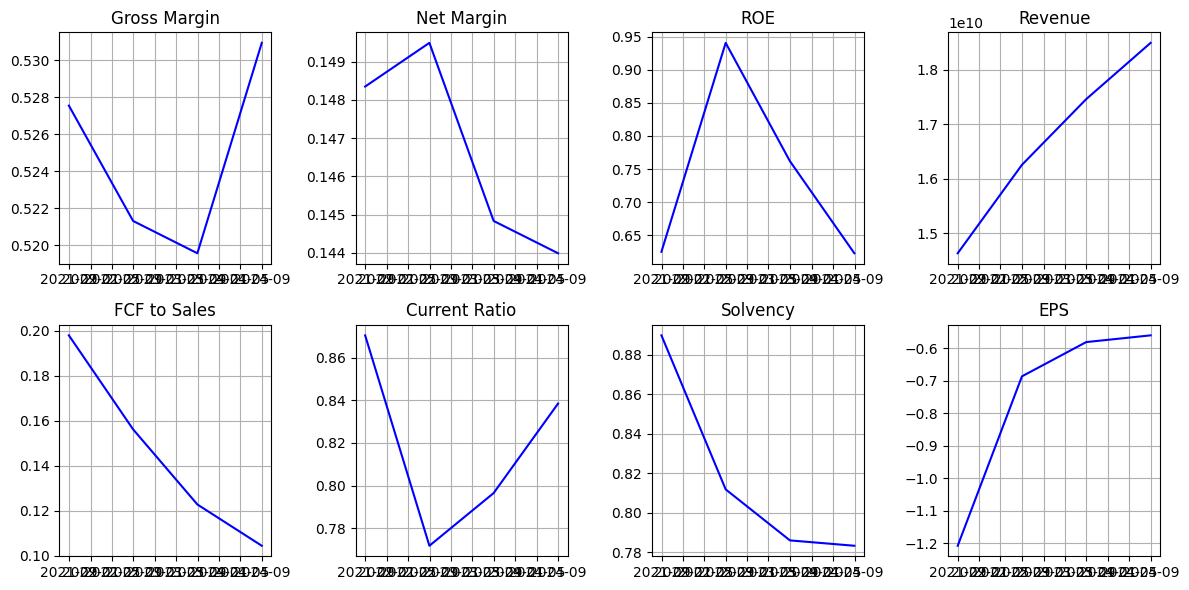

Múltiplos de META


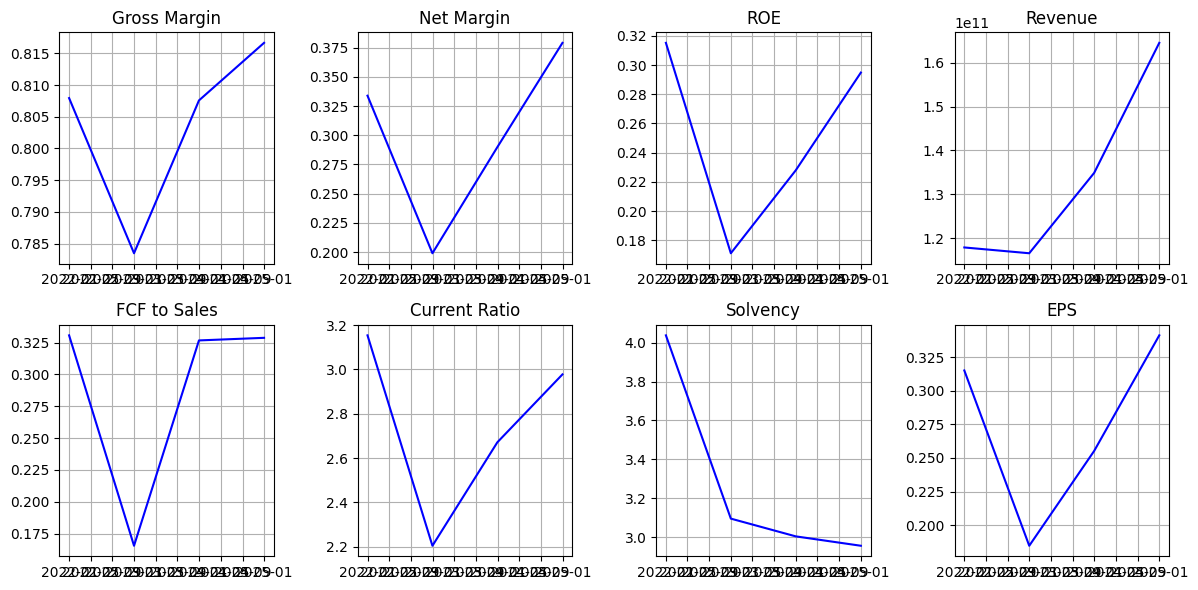

Múltiplos de NEM


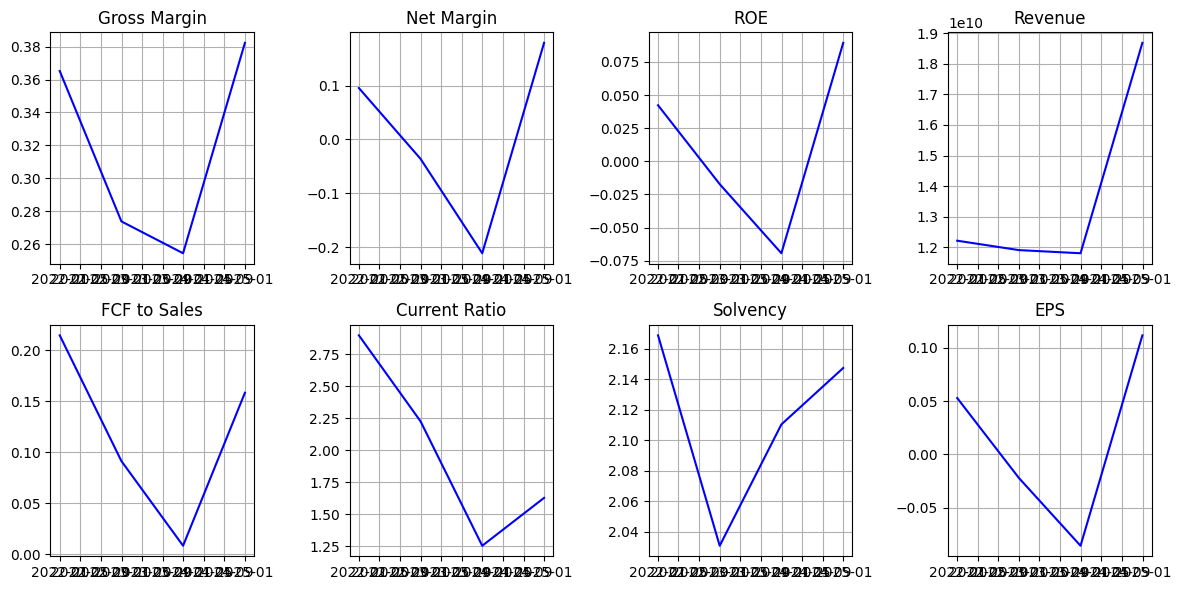

Múltiplos de ED


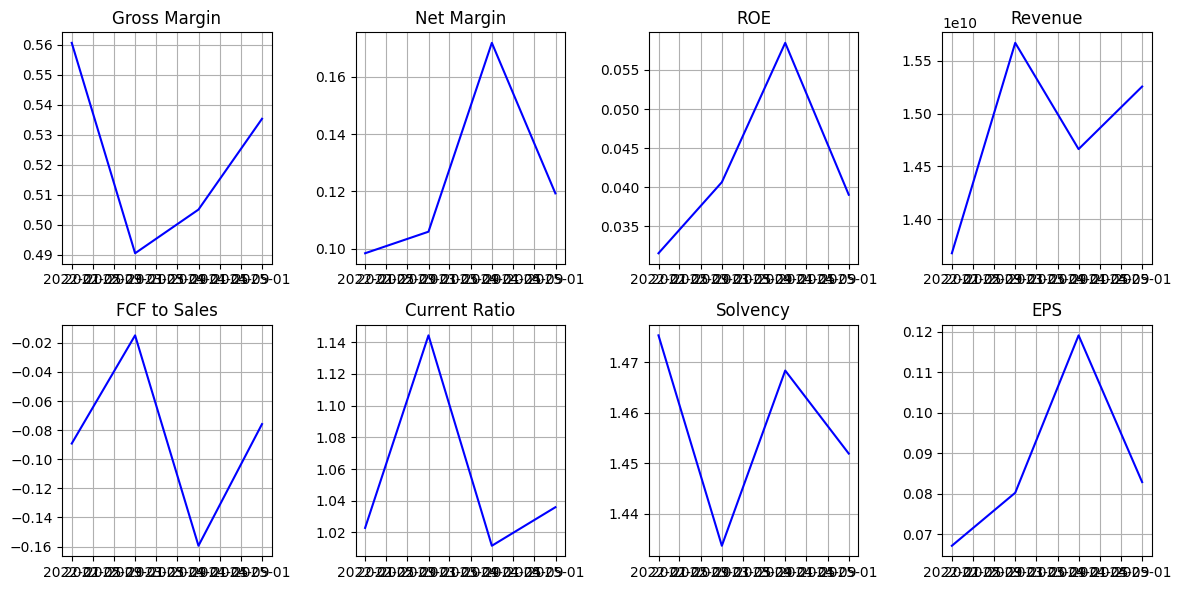

Múltiplos de WMT


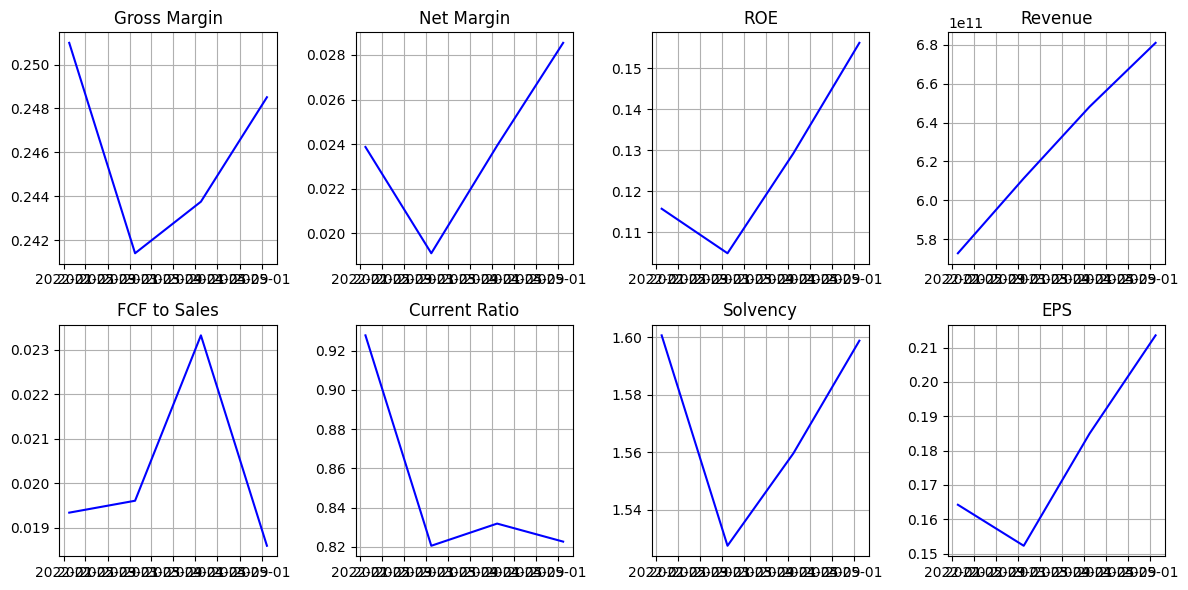

In [460]:
for ticker in tickers_valuation[:5]:

    bs, ist, cf = get_financials(ticker)

    gross_margin = ist.loc['Gross Profit']/ist.loc['Total Revenue']

    net_margin = ist.loc['Net Income Common Stockholders']/ist.loc['Total Revenue']

    roe = ist.loc['Net Income Common Stockholders'] / bs.loc['Total Capitalization']

    revenue = ist.loc['Total Revenue']

    fcf_to_sales = cf.loc['Free Cash Flow'] / ist.loc['Total Revenue']

    current_ratio = bs.loc['Current Assets']/bs.loc['Current Liabilities']

    solvency = bs.loc['Total Assets']/bs.loc['Total Liabilities Net Minority Interest']

    eps = ist.loc['Net Income Common Stockholders'] / bs.loc['Common Stock Equity']

    df_multiplos = pd.DataFrame({
        'Gross Margin': gross_margin,
        'Net Margin': net_margin,
        'ROE': roe,
        'Revenue': revenue,
        'FCF to Sales': fcf_to_sales,
        'Current Ratio': current_ratio,
        'Solvency': solvency,
        'EPS': eps
    })

    df_multiplos.sort_index()

    print(f'Múltiplos de {ticker}')

    fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(12, 6))
    axes = axes.ravel()  # Aplana la matriz de ejes para indexar con un solo número

    for i, column in enumerate(df_multiplos.columns):
        axes[i].plot(df_multiplos.index, df_multiplos.iloc[:, i], c = 'blue')
        axes[i].set_title(column)
        axes[i].grid()
    plt.tight_layout()
    plt.show()

In [461]:
print(analizar_accion("BRK-B"))


Métricas de BRK-B:
Precio Actual: $478.03
EPS (Trailing): $37.53
Price-to-Book (P/B): 0.00
Price-to-Earnings (P/E): 12.74

Evaluación:
P/B ≤ 1.2: Posible infravaloración (umbral de recompra de Buffett).
P/E: 12.74. Compara con el S&P 500 (~15–20) para contexto.


In [462]:
print(analizar_accion("AZO"))


Métricas de AZO:
Precio Actual: $3790.64
EPS (Trailing): $147.46
Price-to-Book (P/B): -15.95
Price-to-Earnings (P/E): 25.71

Evaluación:
P/B ≤ 1.2: Posible infravaloración (umbral de recompra de Buffett).
P/E: 25.71. Compara con el S&P 500 (~15–20) para contexto.


In [463]:
print(analizar_accion("META"))


Métricas de META:
Precio Actual: $718.35
EPS (Trailing): $25.57
Price-to-Book (P/B): 9.80
Price-to-Earnings (P/E): 28.09

Evaluación:
P/B > 1.6: Posible sobrevaloración.
P/E: 28.09. Compara con el S&P 500 (~15–20) para contexto.


In [464]:
print(analizar_accion("NEM"))


Métricas de NEM:
Precio Actual: $60.16
EPS (Trailing): $4.39
Price-to-Book (P/B): 2.16
Price-to-Earnings (P/E): 13.70

Evaluación:
P/B > 1.6: Posible sobrevaloración.
P/E: 13.70. Compara con el S&P 500 (~15–20) para contexto.


In [465]:
print(analizar_accion("ED"))


Métricas de ED:
Precio Actual: $99.71
EPS (Trailing): $5.41
Price-to-Book (P/B): 1.51
Price-to-Earnings (P/E): 18.43

Evaluación:
P/B entre 1.2–1.6: Valuación razonable (rango histórico).
P/E: 18.43. Compara con el S&P 500 (~15–20) para contexto.


In [466]:
print(analizar_accion("WMT"))


Métricas de WMT:
Precio Actual: $99.35
EPS (Trailing): $2.34
Price-to-Book (P/B): 9.47
Price-to-Earnings (P/E): 42.46

Evaluación:
P/B > 1.6: Posible sobrevaloración.
P/E: 42.46. Compara con el S&P 500 (~15–20) para contexto.


---

## Tactical Asset Allocation

### Optimizar Pesos del Portafolio

In [467]:
optimize_port = OptimizePortfolioWeights(returns=ret, risk_free=0.0445)

#### Optimización Minima Varianza

In [468]:
w_minvar = optimize_port.opt_min_var()*0.5
dict_minvar = dict(zip(ret.columns, w_minvar))
dict_minvar

{'AZO': 0.08421113872596356,
 'BRK-B': 0.10899244439502033,
 'ED': 0.17154500923605398,
 'META': 0.04788466639833661,
 'NEM': 0.012607753363936765,
 'WMT': 0.07475898788068873}

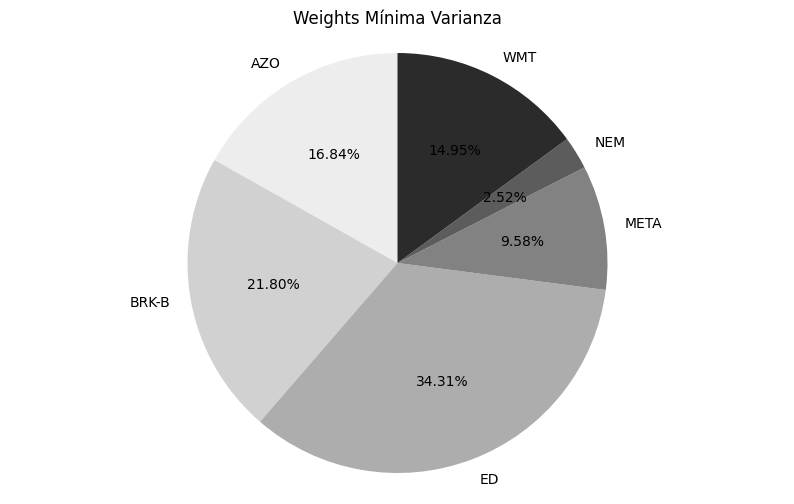

In [469]:
palette = sns.color_palette('Greys', len(w_minvar))

plt.figure(figsize=(10, 6))
plt.pie(
    w_minvar, 
    labels=ret.columns, 
    colors=palette, 
    autopct='%.2f%%', 
    startangle=90
)
plt.title('Weights Mínima Varianza')
plt.axis('equal')
plt.show()

#### Optimización Máximo de Sharpe

In [470]:
w_maxsharpe = optimize_port.opt_max_sharpe()*0.5
dict_maxsharpe = dict(zip(ret.columns, w_maxsharpe))
dict_maxsharpe

{'AZO': 0.11257955733255313,
 'BRK-B': 1.4377222090881111e-18,
 'ED': 0.03370854437175717,
 'META': 0.09468437884802659,
 'NEM': 0.03564886514220123,
 'WMT': 0.22337865430546192}

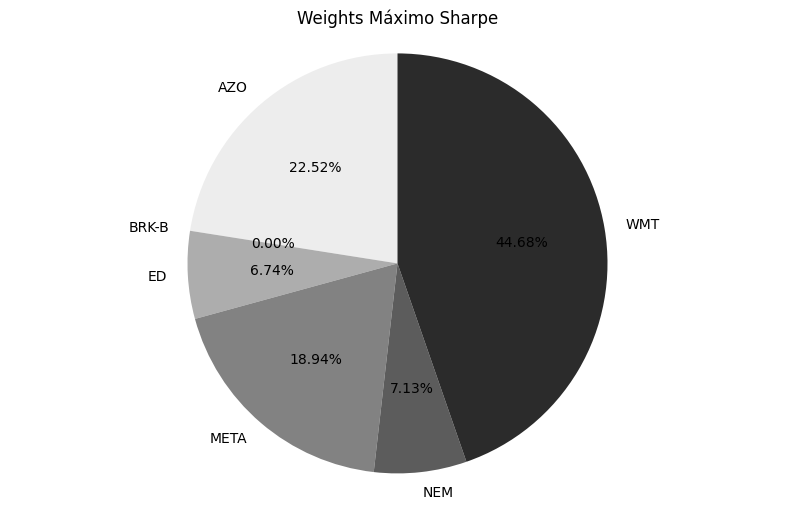

In [471]:
palette = sns.color_palette('Greys', len(w_maxsharpe))

plt.figure(figsize=(10, 6))
plt.pie(
    w_maxsharpe, 
    labels=ret.columns, 
    colors=palette, 
    autopct='%.2f%%', 
    startangle=90
)
plt.title('Weights Máximo Sharpe')
plt.axis('equal')
plt.show()

#### Optimización Semi Varianza Target

In [472]:
w_semivar = optimize_port.opt_min_semivar(rets_benchmark)*0.5
dict_semivar = dict(zip(ret.columns, w_semivar))
dict_semivar

{'AZO': 0.0559791648304874,
 'BRK-B': 0.1734573225745608,
 'ED': 0.07068428292730781,
 'META': 0.09053939307892377,
 'NEM': 0.013130259018878186,
 'WMT': 0.09620957756984201}

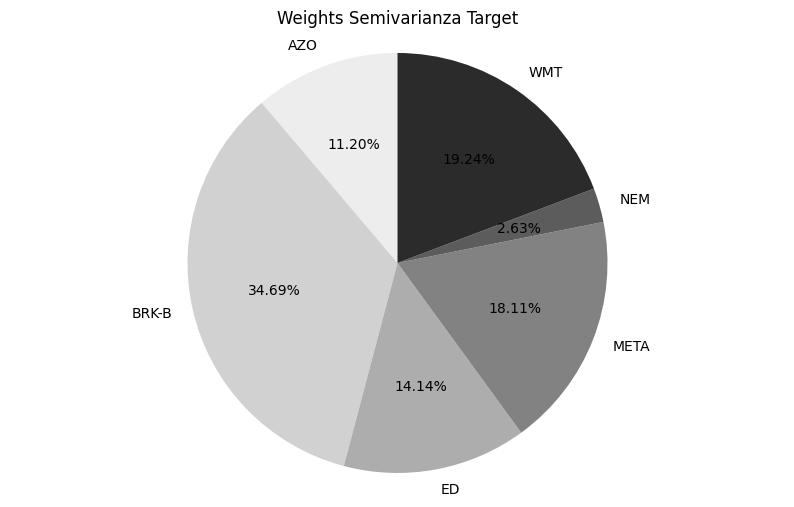

In [473]:
palette = sns.color_palette('Greys', len(w_semivar))

plt.figure(figsize=(10, 6))
plt.pie(
    w_semivar, 
    labels=ret.columns, 
    colors=palette, 
    autopct='%.2f%%', 
    startangle=90
)
plt.title('Weights Semivarianza Target')
plt.axis('equal')
plt.show()

#### Optimización Máximo de Omega

In [474]:
omega = optimize_port.opt_max_omega(rets_benchmark)*0.5
dict_omega = dict(zip(ret.columns, omega))
dict_omega

{'AZO': 0.025,
 'BRK-B': 0.025000000000000015,
 'ED': 0.025000000000000033,
 'META': 0.19999999999999998,
 'NEM': 0.025,
 'WMT': 0.2}

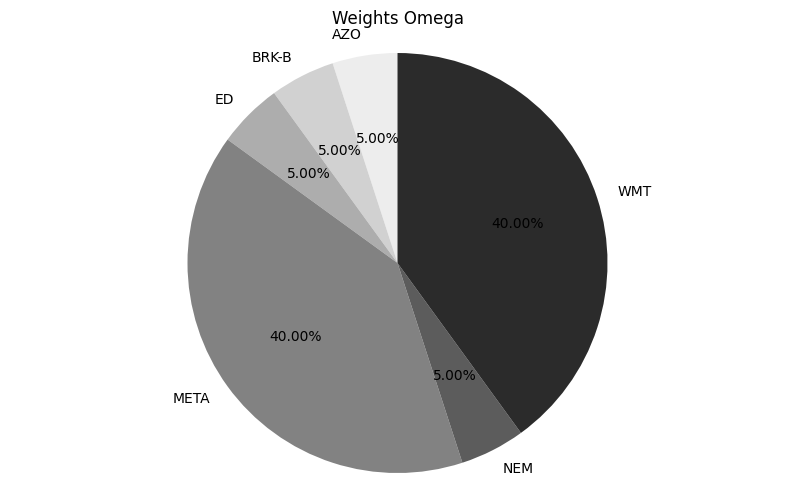

In [475]:
palette = sns.color_palette('Greys', len(omega))

plt.figure(figsize=(10, 6))
plt.pie(
    omega, 
    labels=ret.columns, 
    colors=palette, 
    autopct='%.2f%%', 
    startangle=90
)
plt.title('Weights Omega')
plt.axis('equal')
plt.show()

##### Ponderaciones 

In [476]:
DataFrame_tactical = pd.DataFrame({
    'Mínima Varianza': dict_minvar,
    'Máximo Sharpe': dict_maxsharpe,
    'Mínimo Semivarianza': dict_semivar,
    'Max Omega': dict_omega
})
DataFrame_tactical

,Mínima Varianza,Máximo Sharpe,Mínimo Semivarianza,Max Omega
AZO,0.084211,1.125796e-01,0.055979,0.025
BRK-B,0.108992,1.437722e-18,0.173457,0.025
ED,0.171545,3.370854e-02,0.070684,0.025
META,0.047885,9.468438e-02,0.090539,0.200
NEM,0.012608,3.564887e-02,0.013130,0.025
WMT,0.074759,2.233787e-01,0.096210,0.200


---

## Strategic Asset Allocation

 ### Obtención de Datos


In [477]:
strategic_prices = yf.download(['SHV', 'IEF'], start='2024-01-01', end='2025-07-01', progress=False)['Close']

In [478]:
returns_strategic = strategic_prices.pct_change().dropna()

### Optimizar portafolio Strategic

In [479]:
optimize_strategic = OptimizePortfolioWeights(returns=returns_strategic, risk_free=0.0445)

#### Optimización Mínima Varianza

In [480]:
w_min_var = optimize_strategic.opt_min_var()*0.5
dict_minvar_strategic = dict(zip(returns_strategic.columns, w_min_var))
dict_minvar_strategic

{'IEF': 5.551115123125783e-17, 'SHV': 0.5}

#### Optimización Máximo de Sharpe

In [481]:
w_max_sharpe = optimize_strategic.opt_max_sharpe()*0.5
dict_maxsharpe_strategic = dict(zip(returns_strategic.columns, w_max_sharpe))
dict_maxsharpe_strategic

{'IEF': 3.666329664627805e-26, 'SHV': 0.5}

#### Optimización Semivarianza Target

In [482]:
w_semivar_strategic = optimize_strategic.opt_min_semivar(rets_benchmark)*0.5
dict_semivar_strategic = dict(zip(returns_strategic.columns, w_semivar_strategic))
dict_semivar_strategic

{'IEF': 0.22368584260808153, 'SHV': 0.27631415739191845}

In [483]:
w_omega = optimize_strategic.opt_max_omega(rets_benchmark)*0.5
dict_omega_strategic = dict(zip(returns_strategic.columns, w_omega))
dict_omega_strategic

{'IEF': 0.2, 'SHV': 0.2}

##### Ponderaciones 

In [484]:
DataFrame_strategic = pd.DataFrame({
    'Mínima Varianza': dict_minvar_strategic,
    'Máximo Sharpe': dict_maxsharpe_strategic,
    'Mínimo Semivarianza': dict_semivar_strategic,
    'Max Omega': dict_omega_strategic
})
DataFrame_strategic*100

,Mínima Varianza,Máximo Sharpe,Mínimo Semivarianza,Max Omega
IEF,5.551115e-15,3.666330e-24,22.368584,20.0
SHV,5.000000e+01,5.000000e+01,27.631416,20.0


---

### Portafolio 

In [485]:
combined_df = DataFrame_tactical.add(DataFrame_strategic, fill_value=0)
combined_df = combined_df.div(combined_df.sum())
combined_df_percentage = combined_df * 100

combined_df_percentage

,Mínima Varianza,Máximo Sharpe,Mínimo Semivarianza,Max Omega
AZO,8.421114e+00,1.125796e+01,5.597916,2.777778
BRK-B,1.089924e+01,1.437722e-16,17.345732,2.777778
ED,1.715450e+01,3.370854e+00,7.068428,2.777778
IEF,5.551115e-15,3.666330e-24,22.368584,22.222222
META,4.788467e+00,9.468438e+00,9.053939,22.222222
NEM,1.260775e+00,3.564887e+00,1.313026,2.777778
SHV,5.000000e+01,5.000000e+01,27.631416,22.222222
WMT,7.475899e+00,2.233787e+01,9.620958,22.222222


#### Minima Varianza

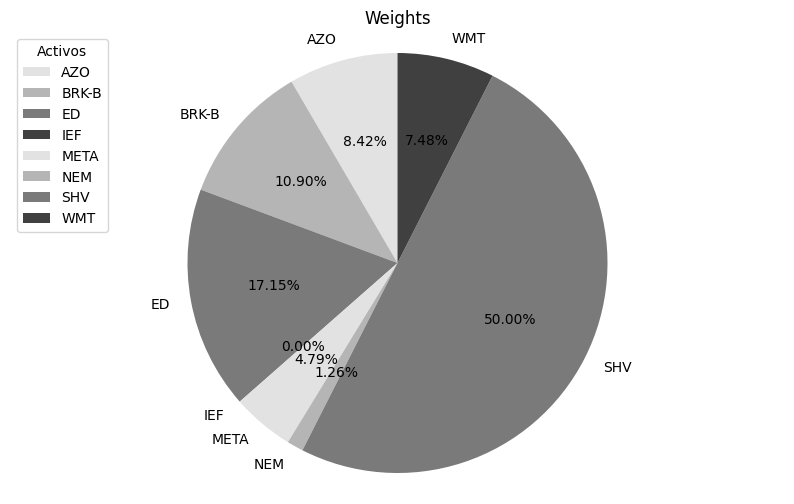

In [486]:
palette = sns.color_palette('Greys', len(combined_df_percentage.columns))

plt.figure(figsize=(10, 6))
plt.pie(
    combined_df_percentage['Mínima Varianza'], 
    labels=combined_df_percentage.index, 
    colors=palette, 
    autopct='%.2f%%', 
    startangle=90
)
plt.title('Weights')
plt.legend(title='Activos', loc='upper left')
plt.axis('equal')
plt.show()

---

### Backtesting

In [487]:
history = dynamic_backtesting(tickers, benchmark, capital=1000000, rf=0.0445, months=6).simulation()
history

,Min Var,Sharpe,Semivar,Omega
Date,,,,
2024-07-02,1.000000e+06,1.000000e+06,1.000000e+06,1.000000e+06
2024-07-03,9.984881e+05,1.001829e+06,9.993615e+05,1.002699e+06
2024-07-05,1.012507e+06,1.028315e+06,1.016202e+06,1.038514e+06
2024-07-08,1.007655e+06,1.021351e+06,1.011185e+06,1.027424e+06
2024-07-09,1.009876e+06,1.023561e+06,1.013069e+06,1.029050e+06
...,...,...,...,...
2025-06-24,1.308642e+06,1.370756e+06,1.330507e+06,1.382353e+06
2025-06-25,1.287750e+06,1.354853e+06,1.309221e+06,1.361705e+06
2025-06-26,1.291701e+06,1.347945e+06,1.313495e+06,1.362951e+06


## Visualización Backtesting

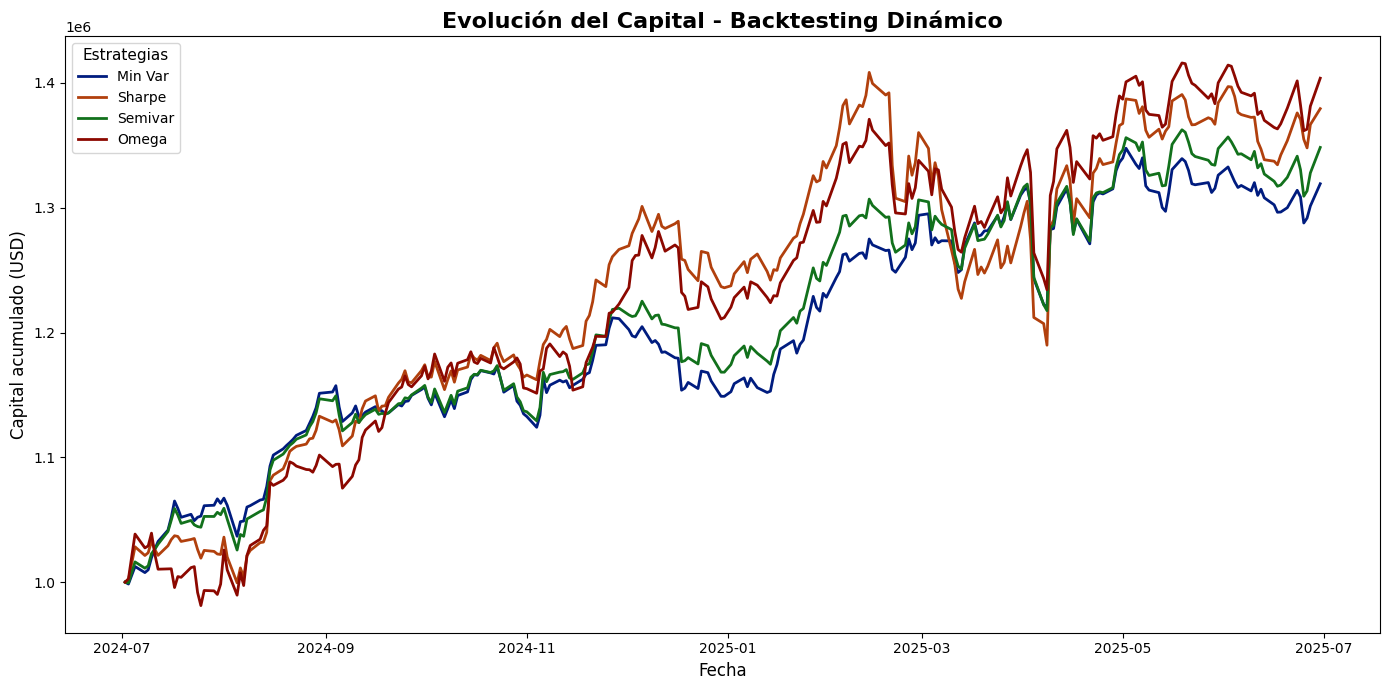

In [488]:
plt.figure(figsize=(14, 7))

colors = sns.color_palette("dark", n_colors=len(history.columns))

for i, col in enumerate(history.columns):
    plt.plot(history.index, history[col], label=col, linewidth=2, color=colors[i])

plt.title('Evolución del Capital - Backtesting Dinámico', fontsize=16, fontweight='bold')
plt.xlabel('Fecha', fontsize=12)
plt.ylabel('Capital acumulado (USD)', fontsize=12)

plt.legend(title="Estrategias", loc='upper left', fontsize=10, title_fontsize=11)
plt.tight_layout()
plt.show()


### Métricas de Desempeño del Portafolio de Inversión


In [489]:
metrics_table = get_metrics(history, rf=0.0445)
metrics_table


,Min Var,Sharpe,Semivar,Omega
Rend,0.291776,0.344530,0.314523,0.361123
Vol,0.142571,0.187992,0.146509,0.180855
Sharpe,1.734401,1.595977,1.843044,1.750696
Downside,0.082547,0.105518,0.082963,0.098560
Upside,0.091927,0.124810,0.096442,0.118886
Omega,1.113629,1.182840,1.162470,1.206233
Sortino,2.995564,2.843412,3.254735,3.212502


---